# Following the tutorial on optimal transport in moscot
https://moscot.readthedocs.io/en/latest/notebooks/tutorials/600_tutorial_translation.html

In [31]:
import moscot.plotting as mtp
from moscot import datasets
from moscot.problems.cross_modality import TranslationProblem

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt

import anndata as ad
import scanpy as sc

In [32]:
import jax
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

We will use the average FOSCTTM (fraction of samples closer to the true match) measure implemented below for evaluation (metric used in [Demetci et al., 2022]). This metric measures the alignment between two domains by computing the average fraction of samples that are closer to their true match than a fixed sample, where a perfect alignment results in a FOSCTTM value of zero.

In [33]:
def foscttm(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i] + foscttm_y[i]) / 2)
    return np.mean(fracs).round(4)

## Data loading

In [34]:
adata_atac = ad.io.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_atac.h5ad")
adata_rna = ad.io.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/data/adata_rna.h5ad")
adata_atac, adata_rna

(AnnData object with n_obs × n_vars = 6224 × 8000
     obs: 'ATAC_nCount_peaks', 'ATAC_nucleosome_signal', 'cell_type', 'batch'
     uns: 'cell_type_colors', 'neighbors'
     obsm: 'ATAC_lsi_full', 'ATAC_lsi_red', 'X_umap', 'geneactivity_scvi'
     layers: 'counts'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 6224 × 2000
     obs: 'GEX_n_counts', 'GEX_n_genes', 'cell_type', 'batch'
     uns: 'cell_type_colors', 'neighbors'
     obsm: 'GEX_X_pca', 'X_umap', 'geneactivity_scvi'
     layers: 'counts'
     obsp: 'connectivities', 'distances')

==> They have the same number of obs, but differing var

In [35]:
adata_atac.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 572601 stored elements and shape (6224, 8000)>

In [37]:
adata_atac.obsm['ATAC_lsi_red'].shape

(6224, 38)

## Preprocessing
We perform a L2-normalization of the ATAC data using sklearn.preprocessing.normalize to scale the samples to have unit norm. This is useful, since we quantify the similarity of pair of samples

In [8]:
adata_atac.obsm["ATAC_lsi_l2_norm"] = pp.normalize(
    adata_atac.obsm["ATAC_lsi_red"], norm="l2"
)

## Visualization
Let’s take a look at the ATAC and RNA data by plotting a UMAP of the respective domain before the alignment, colored according to cell type.

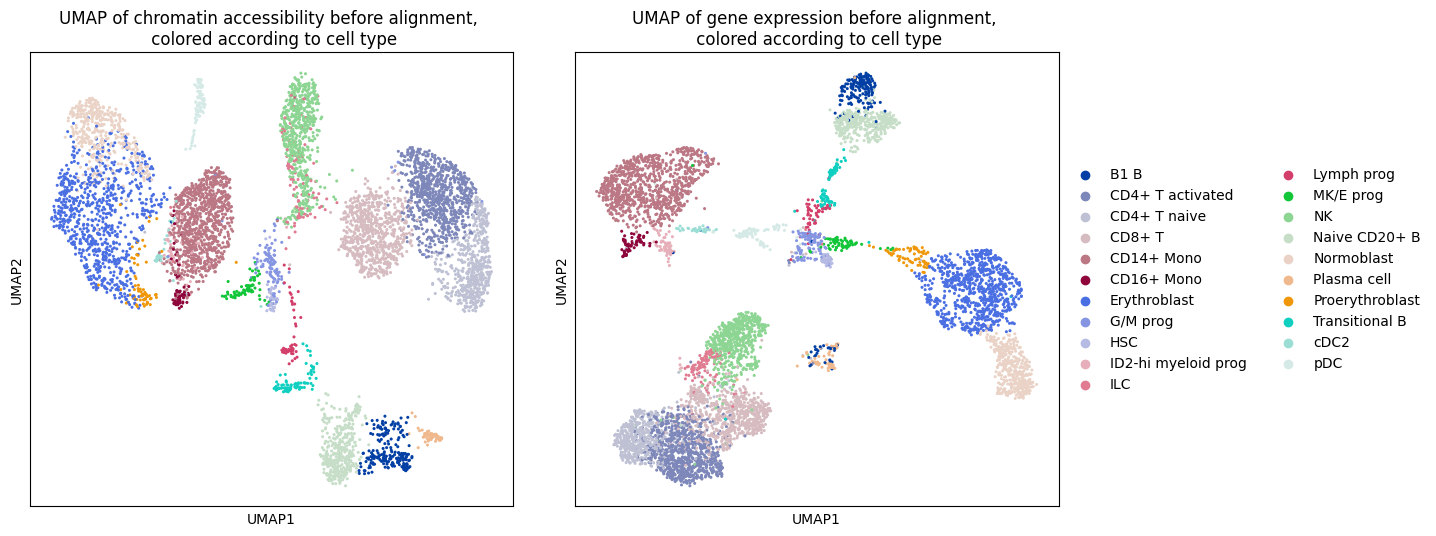

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata_atac, color="cell_type", ax=ax1, show=False)
ax1.legend().remove()
ax1.set_title(
    "UMAP of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.umap(adata_rna, color="cell_type", ax=ax2, show=False)
ax2.set_title(
    "UMAP of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

## Prepare the TranslationProblem
We need to initialize the TranslationProblem by passing the source and target AnnData objects. After initialization, we need to prepare() the problem. In this particular case, we need to pay attention to 3 parameters:

 - src_attr: specifies the attribute in AnnData that contains the source distribution. In our case it refers to the key in obsm that stores the ATAC LSI embedding.

 - tgt_attr: specifies the attribute in AnnData that contains the target distribution. In our case it refers to the key in obsm that stores the RNA PCA embedding.

 - joint_attr[optional]: specifies a joint attribute over a common feature space to incorporate a linear term into the quadratic optimization problem. Initially, we consider the pure Gromov-Wasserstein setting and subsequently explore the fused problem.

In [10]:
adata_atac.obsm["ATAC_lsi_l2_norm"].shape, adata_rna.obsm["GEX_X_pca"].shape

((6224, 38), (6224, 50))

In [11]:
tp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)
tp = tp.prepare(src_attr="ATAC_lsi_l2_norm", tgt_attr="GEX_X_pca")

## Solve the TranslationProblem
In fused quadratic problems, the alpha parameter defines the convex combination between the quadratic and linear terms. By default, alpha = 1, that is, we only consider the quadratic problem, ignoring the joint_attr. We choose a small value for epsilon to obtain a sparse transport map

In [12]:
tp = tp.solve(alpha=1.0, epsilon=1e-3)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          


## TODO: need to check if we can setupt CUDA-enabled Jaxlib
=> Done, works as intended

## Translate the TranslationProblem
We can now project one domain onto the other. The boolean parameter forward determines the direction of the barycentric projection. In our case, we project the source distribution AnnData (ATAC) onto the target distribution AnnData (RNA), therefore we use forward = True. The function translate() returns the translated object in the target space (or source space respectively)

In [13]:
translated = tp.translate(source="src", target="tgt", forward=True)

In [21]:
print(
    "Average FOSCTTM score of translating ATAC onto RNA: ",
    foscttm(adata_rna.obsm["GEX_X_pca"], translated),
)

Average FOSCTTM score of translating ATAC onto RNA:  0.4686


For the sake of visualization, we concatenate the translated chromatin accessibility points mapped to the gene expression PCA domain to the original gene expression PCA data. Then we plot a UMAP of the concatenated data in the gene expression domain, colored according to the original domain and cell type.

In [14]:
adata = sc.concat(
    [adata_atac, adata_rna],
    join="outer",
    label="batch",
    keys=["ATAC (translated)", "RNA"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, adata_rna.obsm["GEX_X_pca"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1")
sc.tl.umap(adata)

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


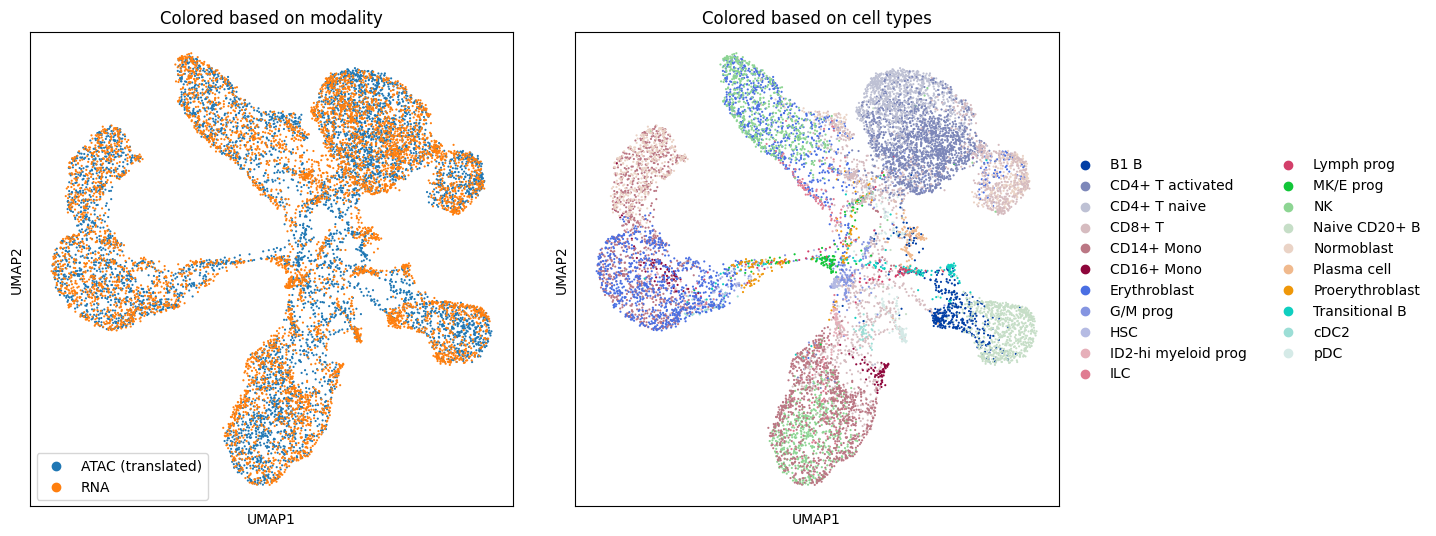

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

# Extend the TranslationProblem to the fused setting

We proceed to extend the TranslationProblem to incorporate the fused setting. In this regard, we aim to evaluate the potential benefits of augmenting the quadratic problem with a linear term. Therefore, we prepare() a new problem, by employing a scVI integration of the gene activity data in the joint_attr. Then, we solve() the resulting problem, with alpha=0.7 and epsilon=.5e-2.

In [16]:
ftp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)
ftp = ftp.prepare(
    src_attr="ATAC_lsi_l2_norm", tgt_attr="GEX_X_pca", joint_attr="geneactivity_scvi"
)
ftp = ftp.solve(epsilon=0.5e-2, alpha=0.7)
translated_fused = ftp.translate(source="src", target="tgt", forward=True)
print(
    "Average FOSCTTM score for translating ATAC onto RNA: ",
    foscttm(adata_rna.obsm["GEX_X_pca"], translated_fused),
)

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(6224, 6224)].                                          
Average FOSCTTM score for translating ATAC onto RNA:  0.0616


## Visualize translation

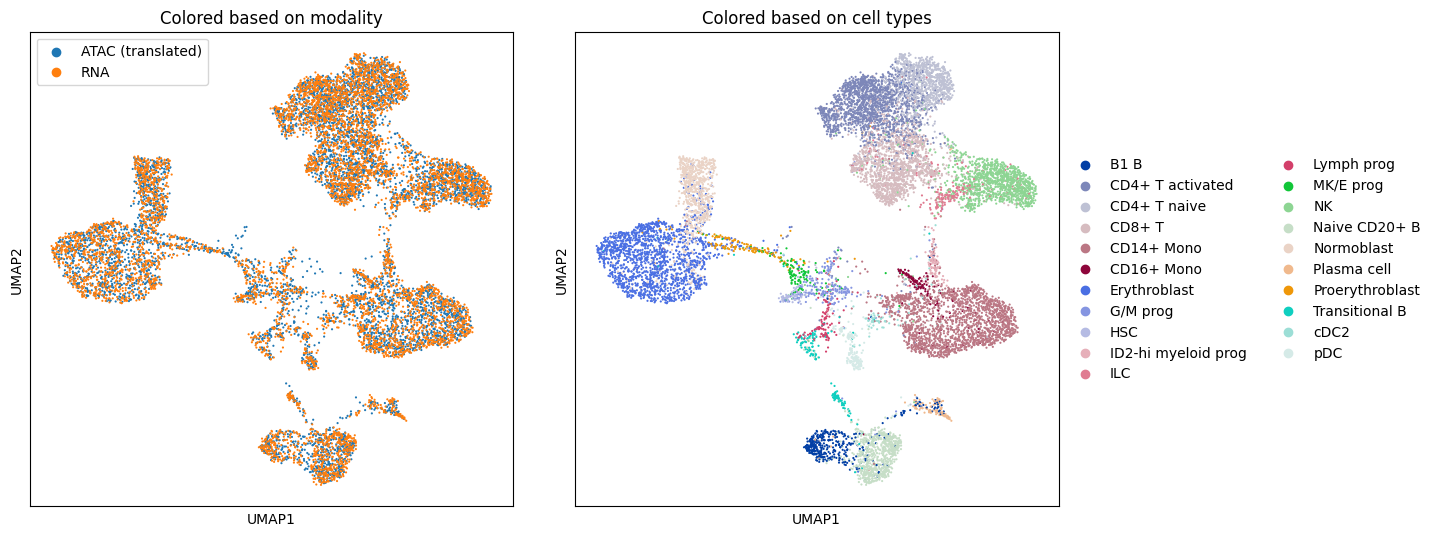

In [17]:
adata.obsm["X_translated_2"] = np.concatenate(
    (translated_fused, adata_rna.obsm["GEX_X_pca"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_2")
sc.tl.umap(adata)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.umap(adata, color=["batch"], ax=ax1, show=False)
ax1.legend()
ax1.set_title("Colored based on modality")
sc.pl.umap(adata, color=["cell_type"], ax=ax2, show=False)
ax2.set_title("Colored based on cell types")
plt.tight_layout(pad=3.0)
plt.show()

## Analyzing cell type transitions
The cell type transition matrix provides a mapping of cell types from one modality to another and can be used to examine the correspondence between cell types across different datasets. The resulting matrix illustrates which cell types are mapped where thereby enabling further downstream analyses. We order the annotations explicitly by providing a dictionary for source_groups and target_groups

In [20]:
type(cell_transition)

pandas.core.frame.DataFrame

In [30]:
order = adata_atac.obs["cell_type"].cat.categories

cell_transition = ftp.cell_transition(
    source="src",
    target="tgt",
    source_groups={"cell_type": order},
    target_groups={"cell_type": order},
    forward=True,
    key_added="ftp_transitions",
)

mtp.cell_transition(ftp, figsize=(5, 5), key_added="ftp_transitions")

KeyError: "No data found in `adata.uns['moscot_results']['cell_transition']['cell_transition']`."

In [1]:
order

NameError: name 'order' is not defined

==> The function tries to access the wrong keys 

In [29]:
ftp.adata.uns['moscot_results']['cell_transition']['ftp_transitions']

{'source': 'src',
 'target': 'tgt',
 'source_groups': {'cell_type': Index(['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD14+ Mono',
         'CD16+ Mono', 'Erythroblast', 'G/M prog', 'HSC', 'ID2-hi myeloid prog',
         'ILC', 'Lymph prog', 'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast',
         'Plasma cell', 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC'],
        dtype='object')},
 'target_groups': {'cell_type': Index(['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', 'CD14+ Mono',
         'CD16+ Mono', 'Erythroblast', 'G/M prog', 'HSC', 'ID2-hi myeloid prog',
         'ILC', 'Lymph prog', 'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast',
         'Plasma cell', 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC'],
        dtype='object')},
 'transition_matrix':                              B1 B  CD4+ T activated  CD4+ T naive  \
 B1 B                 7.467691e-01      5.989771e-03  2.179921e-04   
 CD4+ T activated     6.740459e-04      7.222140e-01  1.54600